In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from K2TranPixCode import *
import lightkurve as lk

In [2]:
save = './test/'
SN2018oh = '../Data/ktwo228682548-c16_lpd-targ.fits.gz'
sn2017k = '../Data/ktwo211545516-c16_lpd-targ.fits.gz'
sn2018p = '../Data/ktwo251502099-c17_lpd-targ.fits.gz'
sn2018ajj = '../Data/ktwo212806553-c17_lpd-targ.fits.gz'

In [30]:
file = sn2018ajj
hdu = fits.open(file)
if len(hdu) > 1:
    dat = hdu[1].data
else:
    print('Broken file ', pixelfile)
    
datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data
if datacube.shape[1] > 1 and datacube.shape[2] > 1:
    #datacube = Clip_cube(datacube)

    time = dat["TIME"] + 2454833.0
    Qual = hdu[1].data.field('QUALITY')
    #thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) | (Qual == 1097760) | (Qual == 1048580) | (Qual == 1081348))[0]
    #thrusters = np.insert(thrusters,0,-1)
    #thrusters = np.append(thrusters,len(datacube)-2)
    thrusters = Get_all_resets(datacube,Qual)
    quality = np.where(Qual != 0)[0]

    xdrif = dat['pos_corr1']
    ydrif = dat['pos_corr2']
    distdrif = np.sqrt(xdrif**2 + ydrif**2)
    if len(distdrif) != len(datacube):
        err_string = 'Distance arr is too short for {file}: len = {leng}'.format(file = pixelfile, leng = len(distdrif))
        raise ValueError(err_string) 

    goodthrust = thrusters[np.where(distdrif[thrusters]<0.2)]
    #calculate the reference frame
    if len(goodthrust) > 4:
        Framemin = goodthrust[3]+1
    elif len(goodthrust) > 0:
        Framemin = goodthrust[0]+1
    else:
        Framemin = 100 # Arbitrarily chosen, Data is probably screwed anway if there are no thruster firings.
    # Apply object mask to data
    Mask = ThrustObjectMask(datacube,goodthrust)

    #Maskdata, ast = First_pass(np.copy(datacube),Qual,quality,thrusters,pixelfile)
    Maskdata = np.copy(datacube)
    allMask = np.ones((datacube.shape[1],datacube.shape[2]))
    Maskdata = Correct_motion(datacube, distdrif, thrusters)

<IPython.core.display.Javascript object>


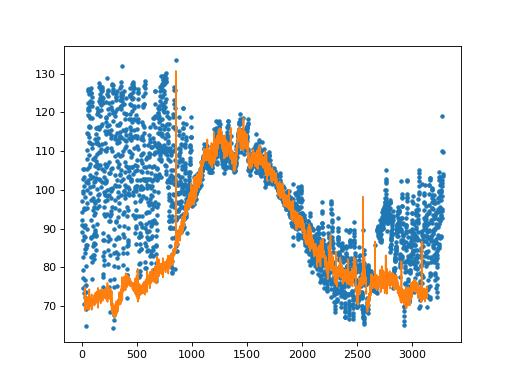

In [20]:
plt.figure()
plt.plot(datacube[:,6,5],'.')
plt.plot(Maskdata[:,6,5])

#for t in thrusters:
#    plt.axvline(t,color='k')

In [190]:
lcs = [Maskdata[:,9,9]]
e = 0
x = np.arange(0,len(lcs[e]))
ind = np.isfinite(lcs[e])
fun = interp1d(x[ind],lcs[e][ind],bounds_error = False)
nonan = fun(x)
width = 10*48 - 1

sm = savgol_filter(nonan,width,2,mode='nearest')
pea = find_peaks(sm)[0]


<IPython.core.display.Javascript object>


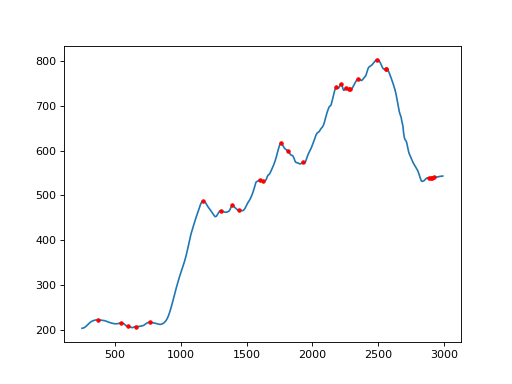

In [191]:
plt.figure()
plt.plot(sm)
for p in pea:
    plt.plot(p,sm[p],'r.')

In [95]:
sigma_clip(sm[pea],masked=True).mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

<IPython.core.display.Javascript object>


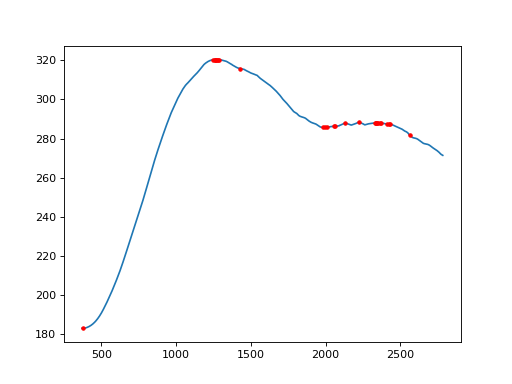

In [84]:
plt.figure()
plt.plot(sm)
for p in pea:
    plt.plot(p,sm[p],'r.')

In [13]:
pea

array([ 268,  279,  284,  289,  291,  294,  300,  303,  305,  313,  315,
        317,  324,  328,  331,  341,  347,  349,  351,  360,  364,  373,
        377,  391,  396,  400,  403,  407,  409,  411,  414,  418,  423,
        433,  439,  446,  458,  466,  468,  470,  474,  482,  488,  492,
        501,  515,  517,  522,  525,  528,  530,  539,  545,  552,  554,
        556,  558,  564,  567,  571,  576,  585,  630,  657,  681,  690,
        698,  708,  710,  719,  723,  728,  734,  737,  748,  752,  760,
        771,  774,  780,  783,  785,  790,  804,  809,  812,  817,  820,
        826,  829,  832,  836,  842,  846,  863,  869,  872,  878,  881,
        900,  903,  907,  911,  914,  916,  924,  929,  936,  939,  941,
        944,  946,  948,  952,  969,  977,  987,  994, 1000, 1040, 1044,
       1049, 1053, 1062, 1067, 1070, 1073, 1081, 1086, 1095, 1097, 1104,
       1106, 1108, 1110, 1113, 1119, 1121, 1123, 1127, 1129, 1134, 1142,
       1145, 1151, 1154, 1156, 1159, 1164, 1168, 11

In [28]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [29]:
X,Y = np.where(np.isfinite(np.nansum(Maskdata,axis=0)))
eh = []
for k in range(1):#len(X)):
    #lcs = [Maskdata[:,X[k],Y[k]]]
    lcs = [Maskdata[:,7,5]]
    e = 0
    x = np.arange(0,len(lcs[e]))
    ind = np.isfinite(lcs[e])
    fun = interp1d(x[ind],lcs[e][ind],bounds_error = False)
    nonan = fun(x)
    width = 5*48 - 1

    sm = savgol_filter(nonan,width,2,mode='nearest')
    pea = find_peaks(sm,distance=width)[0]
    
    data = np.array(list(zip(pea,sm[pea])))
    
    clus = 3
    kmeans = KMeans(n_clusters=clus)
    kmeans = kmeans.fit(data)
    labels = kmeans.predict(data)

    std = []
    mean = []
    for i in range(clus):
        m = labels == i
        std += [np.std(sm[pea[m]])]
        mean += [np.mean(sm[pea[m]])]
    std = np.array(std)
    mean = np.array(mean)
    nlab = labels.copy()
    labs = np.arange(0,clus)
    i = 0
    while i < len(std):
        test = ((mean[i] + 3*std[i]) >= mean) & ((mean[i] - 3*std[i]) <= mean)
        if sum(test) > 1:
            for j in range(sum(test)):
                nlab[nlab == j] = i
            std[i] = np.std(sm[pea[nlab == i]])
            mean[i] = np.mean(sm[pea[nlab == i]])
            test[i] = False
            std = std[~test]
            mean = mean[~test]
        else:
            i += 1

    if len(std) > 1:
        print('vary')
        eh += [k]
        plt.figure()
        plt.plot(sm)
        for p in pea:
            plt.plot(p,sm[p],'r.')


start only
[36.17546014] 50.47562485995731


<IPython.core.display.Javascript object>


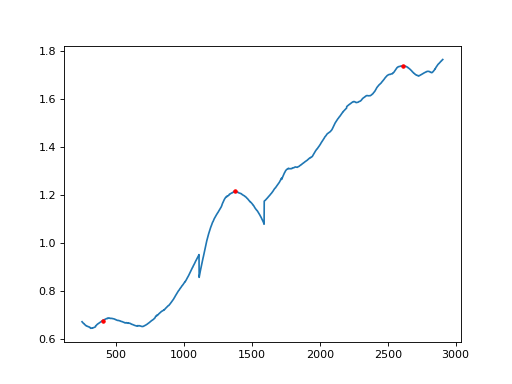

[15.50273342] 15.815279103265645


<IPython.core.display.Javascript object>


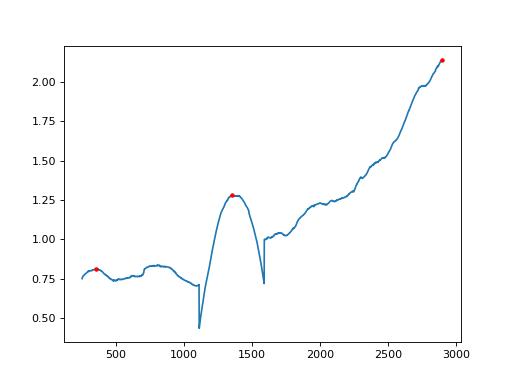

start only
start only
start only
[13.4795947] 8.652384760825898


<IPython.core.display.Javascript object>


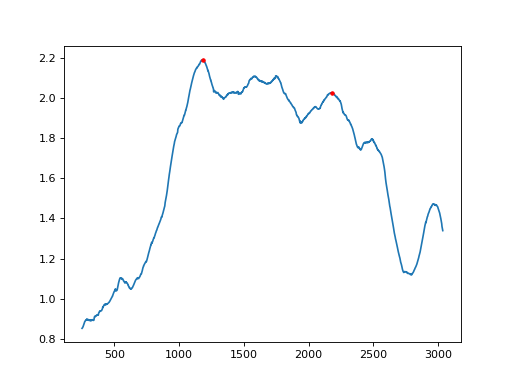

start only
start only
start only
start only
[10.69736834] 14.323408823706469


<IPython.core.display.Javascript object>


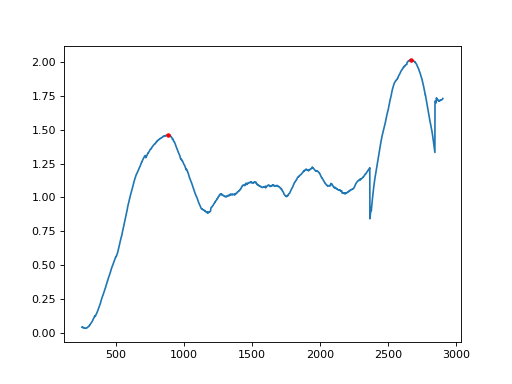

start only
start only
[762.35019427] 772.3739552702143


<IPython.core.display.Javascript object>


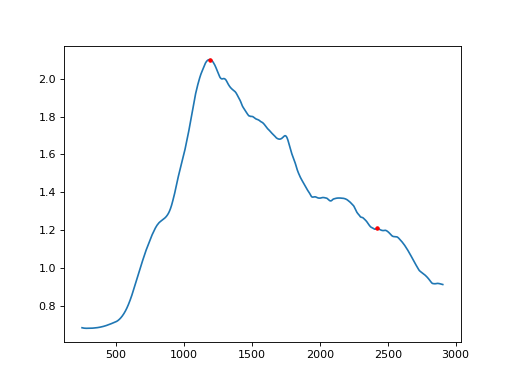

start only
[257.46469313] 147.5225387066204


<IPython.core.display.Javascript object>


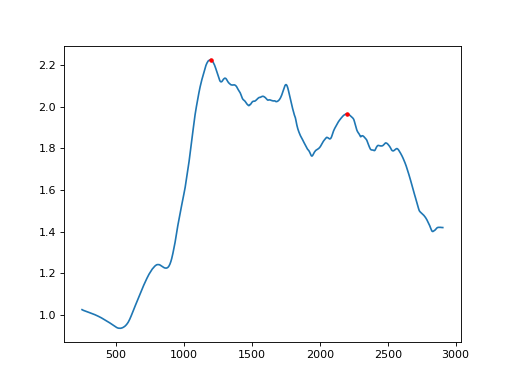

start only
start only
start only
start only
[151.15964458] 114.49907368052911


<IPython.core.display.Javascript object>


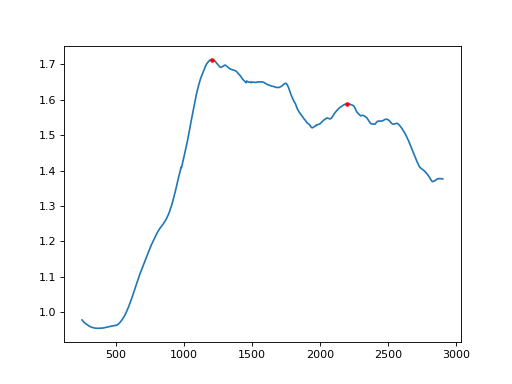

[1618.42726888] 1742.1450516500508


<IPython.core.display.Javascript object>


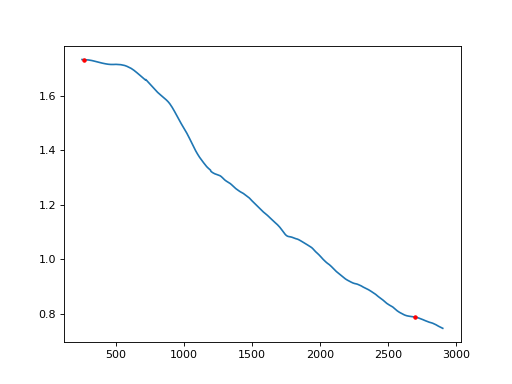

[99.88501278] 88.62012752903199


<IPython.core.display.Javascript object>


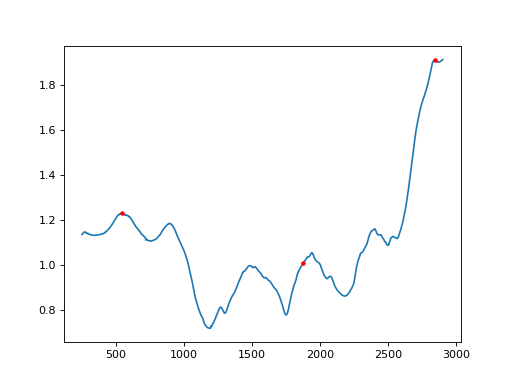

[214.81734544] 158.01818264620712


<IPython.core.display.Javascript object>


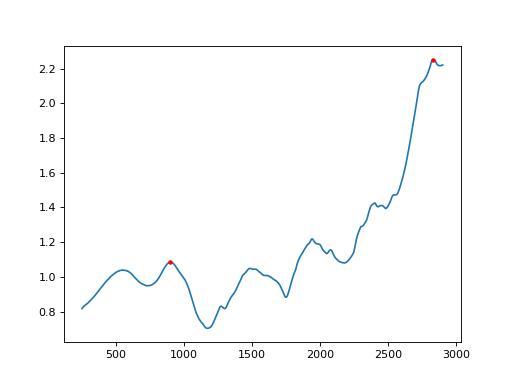

start only
[14.48212775] 8.515555066064483


<IPython.core.display.Javascript object>


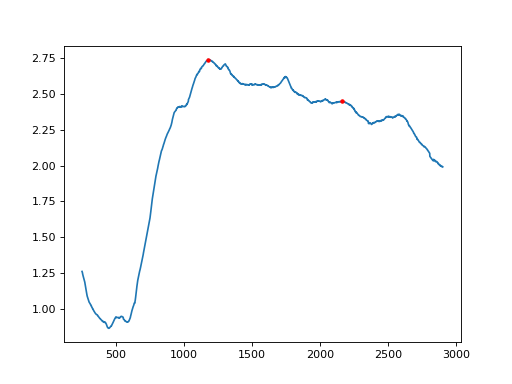

In [30]:
X,Y = np.where(np.isfinite(np.nansum(Maskdata,axis=0)))
eh = []
for k in range(len(X)):
    lcs = [Maskdata[:,X[k],Y[k]]]
    #lcs = [Maskdata[:,11,6]]
    e = 0
    x = np.arange(0,len(lcs[e]))
    ind = np.isfinite(lcs[e])
    fun = interp1d(x[ind],lcs[e][ind],bounds_error = False)
    nonan = fun(x)
    width = 10*48 - 1

    sm = savgol_filter(nonan,width,2,mode='nearest')
    pea = find_peaks(sm,distance=2*width)[0]
    maxpeak = pea[np.where(sm[pea] == np.nanmax(sm[pea]))[0]]
    
    
    ind = np.arange(0,len(Maskdata))
    m_s = ind < int(maxpeak-width)
    m_e = ind > int(maxpeak+2*width)
    mean_start = np.nanmean(sm[m_s]) 
    mean_end   = np.nanmean(sm[m_e]) 
    
    std_start = np.nanstd(sm[m_s])
    std_end = np.nanstd(sm[m_e])
    
    if np.isfinite(mean_start) & np.isfinite(mean_end):
        if mean_end > (mean_start + 5*std_start):
            print('start only')
            mean_outside = mean_start
            std_outside = std_start
        else:
            mean_outside = np.nanmean(sm[m_s+m_e])
            std_outside = np.nanstd(sm[m_s+m_e])
    else:
        mean_outside = np.nanmean(sm[m_s+m_e])
        std_outside = np.nanstd(sm[m_s+m_e])
    
    if ((sm[maxpeak]/mean_outside) > 1.7) & (sm[maxpeak] > 10):
        print(sm[maxpeak], mean_outside + 5*std_outside)
        plt.figure()
        plt.plot(sm/mean_outside)
        for p in pea:
            plt.plot(p,sm[p]/mean_outside,'r.')
        eh += [k]

In [293]:

obj = np.ma.masked_invalid(Mask).mask
objmed = np.nanmedian(Maskdata[thrusters[:-1]+4]*obj,axis=(0))
objstd = np.nanstd(Maskdata[thrusters[:-1]+4]*obj,axis=(0))

framemask = np.zeros_like(Maskdata)

med = np.nanmedian(Maskdata[Qual == 0], axis = (0))
med[med < 0] = 0

limit = med+3*(np.nanstd(Maskdata[Qual == 0], axis = (0)))
limit[limit<22] = 22
framemask = (Maskdata/limit)
framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0

# Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 
Eventmask = np.copy(framemask)
#Eventmask[~np.where((convolve(framemask,np.ones((5,1,1)), mode='constant', cval=0.0) >= 4))[0]] = 0
Eventmask[Qual!=0,:,:] = 0

funny_keywords = {'1CTYP4': 'CTYPE1',
                  '2CTYP4': 'CTYPE2',
                  '1CRPX4': 'CRPIX1',
                  '2CRPX4': 'CRPIX2',
                  '1CRVL4': 'CRVAL1',
                  '2CRVL4': 'CRVAL2',
                  '1CUNI4': 'CUNIT1',
                  '2CUNI4': 'CUNIT2',
                  '1CDLT4': 'CDELT1',
                  '2CDLT4': 'CDELT2',
                  '11PC4': 'PC1_1',
                  '12PC4': 'PC1_2',
                  '21PC4': 'PC2_1',
                  '22PC4': 'PC2_2'}
mywcs = {}
for oldkey, newkey in funny_keywords.items():
    mywcs[newkey] = hdu[1].header[oldkey] 
mywcs = WCS(mywcs)

Objmasks = Watershed_object_sep(obj)

In [20]:
file

'../Data/ktwo251502099-c17_lpd-targ.fits.gz'

In [32]:
def Find_Long_Events(Data,Time,Eventmask,Objmasks,Mask,Thrusters,Dist,Quality,WCS,HDU,File,Save):
    '''
    Wrapper function for the long events finding routine.
    '''
    X,Y = np.where(np.isfinite(np.nansum(Data,axis=0)))
    x = np.arange(0,len(Data))
    smoothed = np.zeros_like(Data)
    for i in range(len(X)):
        lcs = Data[:,X[i],Y[i]]
        ind = np.isfinite(lcs)
        if len(lcs[ind]) > 10:
            fun = interp1d(x[ind],lcs[ind],bounds_error = False)
            nonan = fun(x)
            width = 10*48 - 1
            sm = savgol_filter(nonan,width,2,mode='nearest')
            smoothed[:,X[i],Y[i]] = sm
        else:
            smoothed[:,X[i],Y[i]] = np.nan
    Data = smoothed
    long_mask, long_time = Long_events(smoothed,Time, Mask,Dist,Save,File)
    long_time = np.array(long_time)
    if len(long_time.shape) == 3:
        long_time = long_time[:,:,0]
    Long_Source, Long_Type = Database_check_mask(Data,Thrusters,long_mask,WCS)

    if len(long_mask) > 0:
        ObjName, ObjType = Database_check_mask(Data,Thrusters,Objmasks,WCS)
        In = In_long_mask(long_mask,Objmasks,Data)
        Long_Maskobj = np.zeros((len(long_mask),Data.shape[1],Data.shape[2])) # for plotting masked object reference
        Maskobj = np.zeros((len(long_mask),Data.shape[1],Data.shape[2])) # for plotting masked object reference

        if len(np.where(Objmasks[:,int(Data.shape[1]/2),int(Data.shape[2]/2)] == 1)[0]) > 0:
            CentralMask = np.where(Objmasks[:,int(Data.shape[1]/2),int(Data.shape[2]/2)] == 1)[0]
        elif len(np.where(Objmasks[:,int(Data.shape[1]/2),int(Data.shape[2]/2)] == 1)[0]) > 1:
            CentralMask = np.where(Objmasks[:,int(Data.shape[1]/2),int(Data.shape[2]/2)] == 1)[0][0]
        else:
            CentralMask = -1
        if CentralMask == -1:
            Maskobj[:] = Mask
        else:
            Maskobj[:] = Objmasks[CentralMask]

        for ind in np.where(In != -1)[0]:
            Long_Source[ind] = 'In: ' + ObjName[In[ind]]
            Long_Type[ind] = 'In: ' + ObjType[In[ind]]
            Long_Maskobj[ind] = Objmasks[In[ind]]
        # Remove all stars!   
        good_ind = np.ones(len(long_time))
        for i in range(len(long_time)):
            if 'Star' in Long_Source[i]:
                good_ind[i] = 0
        
        good_ind = good_ind > 0

        long_time = long_time[good_ind]

        mask_ind = np.where(~good_ind)[0]
        for i in range(len(mask_ind)):
            rev = len(mask_ind) -1 - i
            del long_mask[rev]
            del Long_Source[rev]
            del Long_Type[rev]

        if len(long_mask) != len(long_time):
            print('long event masks, ', len(long_mask))
            print('long events, ', len(long_time))
            raise ValueError('Arrays are different lengths, check whats happening in {}'.format(pixelfile))

        Long_figure(long_mask, long_time, Data, WCS, Time, Save, File, Long_Source, Long_Type, Long_Maskobj, Eventmask)
        #long_saves = LongK2TranPixZoo(long_mask, long_time, Long_Source, Long_Type, Data, Time, WCS, Save, File)
        #Write_long_event(File, long_mask, long_time, Long_Source, Long_Type,long_saves, Data, Quality, WCS, HDU, Save)
    return

In [11]:
events, eventtime, eventmask = Event_ID(Eventmask, 1, 5)
#events, eventtime, eventmask = Vet_brightness(np.copy(events),np.copy(eventtime),eventmask,np.copy(Maskdata),Qual,pixelfile)
events, eventtime, eventmask = Match_events(events,eventtime,eventmask,Maskdata)
events, eventtime, eventmask = Vet_peaks(events, eventtime, eventmask, Maskdata)

<IPython.core.display.Javascript object>


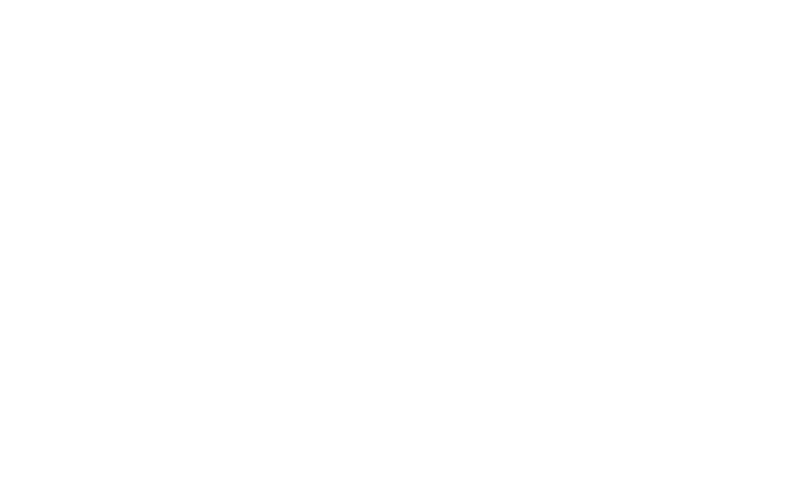

<IPython.core.display.Javascript object>


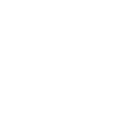

<IPython.core.display.Javascript object>


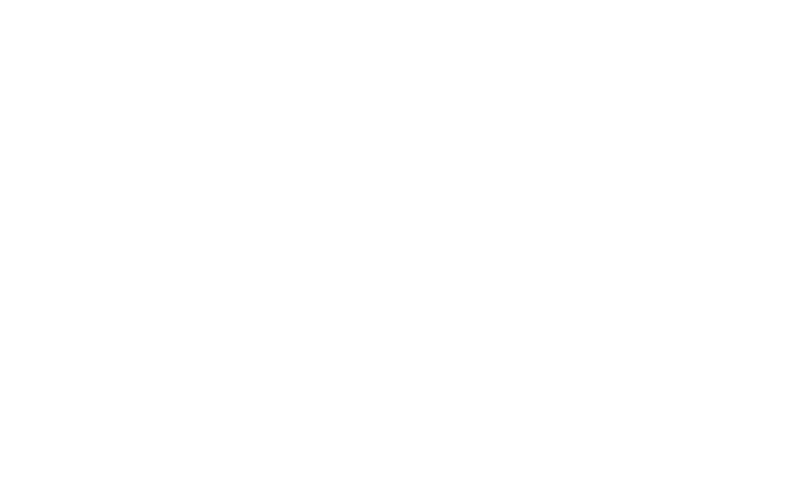

<IPython.core.display.Javascript object>


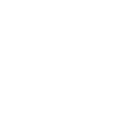

<IPython.core.display.Javascript object>


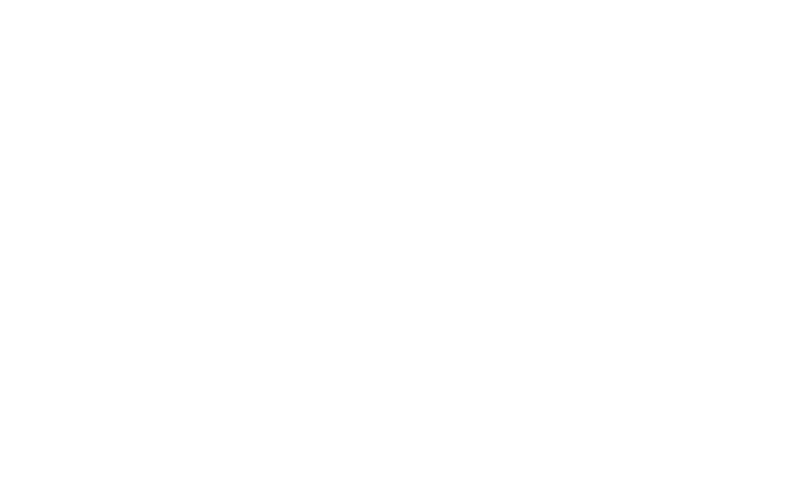

<IPython.core.display.Javascript object>


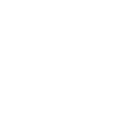

<IPython.core.display.Javascript object>


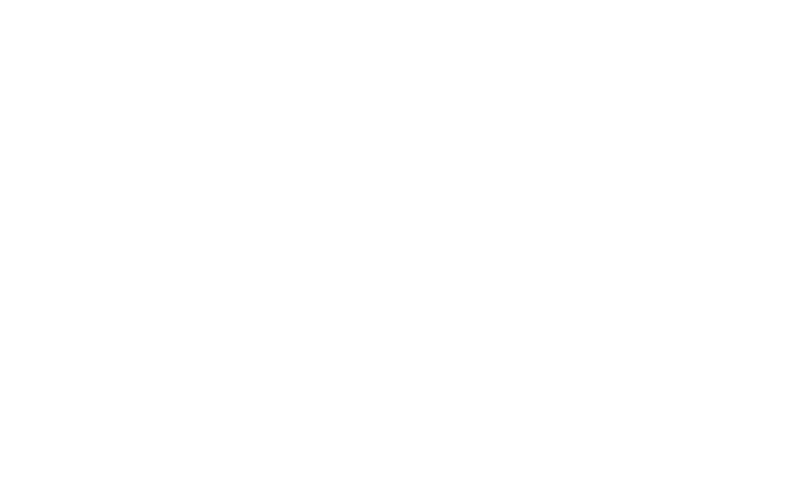

<IPython.core.display.Javascript object>


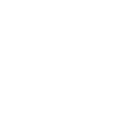

<IPython.core.display.Javascript object>


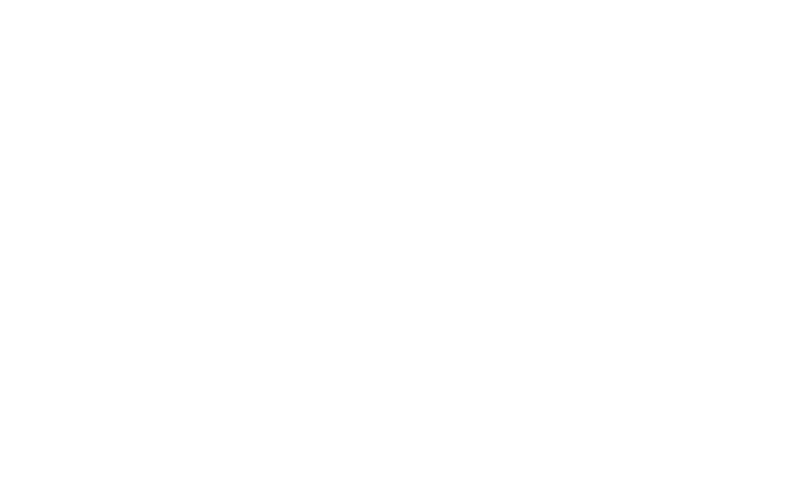

<IPython.core.display.Javascript object>


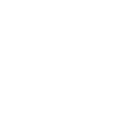

In [33]:
Find_Long_Events(Maskdata,time,(Eventmask >= 0),Objmasks,Mask,thrusters,np.copy(distdrif),Qual,mywcs,hdu,file,'./test/')

In [26]:
lcs = [Maskdata[:,10,7]]
e = 0
x = np.arange(0,len(lcs[e]))
ind = np.isfinite(lcs[e])
fun = interp1d(x[ind],lcs[e][ind],bounds_error = False)
nonan = fun(x)
width = 5*48 - 1

sm = savgol_filter(nonan,width,2,mode='mirror')

<IPython.core.display.Javascript object>


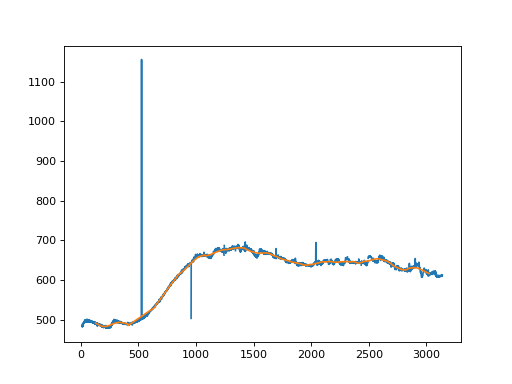

In [27]:
plt.figure()
plt.plot(Maskdata[:,10,7])
plt.plot(sm)

In [ ]:
pea = find_peaks(sm,distance=2*width)[0]
maxpeak = pea[np.where(sm[pea] == np.nanmax(sm[pea]))[0]]


ind = np.arange(0,len(smoothed))
m_s = ind < int(maxpeak-width)
m_e = ind > int(maxpeak+2*width)
mean_start = np.nanmean(sm[m_s]) 
mean_end   = np.nanmean(sm[m_e]) 

std_start = np.nanstd(sm[m_s])
std_end = np.nanstd(sm[m_e])

if np.isfinite(mean_start) & np.isfinite(mean_end):
    if mean_end > (mean_start + 5*std_start):
        print('start only')
        mean_outside = mean_start
        std_outside = std_start
    else:
        mean_outside = np.nanmean(sm[m_s+m_e])
        std_outside = np.nanstd(sm[m_s+m_e])
else:
    mean_outside = np.nanmean(sm[m_s+m_e])
    std_outside = np.nanstd(sm[m_s+m_e])

In [294]:
x = np.arange(0,len(Maskdata))
distdrif[distdrif > 10] = np.nan
ind = np.isfinite(distdrif)
fun = interp1d(x[ind],distdrif[ind],bounds_error = False)
nonan = fun(x)
width = 5*48 - 1
sm_dist = savgol_filter(nonan,width,2,mode='nearest')
dist_ind = np.where(sm_dist > 0.4)[0]

X,Y = np.where(np.isfinite(np.nansum(Maskdata,axis=0)))

smoothed = np.zeros_like(Maskdata)
limit = np.zeros_like(Maskdata[0]) * np.nan
for i in range(len(X)):
    lcs = Maskdata[:,X[i],Y[i]]
    lcs[distdrif > .3] = np.nan
    ind = np.isfinite(lcs)
    if len(lcs[ind]) > 10:
        fun = interp1d(x[ind],lcs[ind],bounds_error = False)
        nonan = fun(x)
        width = 5*48 - 1
        sm = savgol_filter(nonan,width,2,mode='nearest')
        smoothed[:,X[i],Y[i]] = sm
        
        pea = find_peaks(sm,distance=4*width)[0]
        maxpeak = pea[np.where(sm[pea] == np.nanmax(sm[pea]))[0]]

        ind = np.arange(0,len(smoothed))
        m_s = ind < int(maxpeak-2*width)
        m_e = ind > int(maxpeak+4*width)
        mean_start = np.nanmean(sm[m_s]) 
        mean_end   = np.nanmean(sm[m_e]) 

        std_start = np.nanstd(sm[m_s])
        std_end = np.nanstd(sm[m_e])
        if maxpeak not in dist_ind:
            if np.isfinite(mean_start) & np.isfinite(mean_end):
                if mean_end > (mean_start + 3*std_start):
                    print('start only')
                    mean_outside = mean_start
                    std_outside = std_start
                else:
                    mean_outside = np.nanmean(sm[m_s+m_e])
                    std_outside = np.nanstd(sm[m_s+m_e])
            else:
                mean_outside = np.nanmean(sm[m_s+m_e])
                std_outside = np.nanstd(sm[m_s+m_e])
            limit[X[i],Y[i]] = mean_outside +3*std_outside
        else:
            limit[X[i],Y[i]] = np.nan#sm[maxpeak]
    else:
        smoothed[:,X[i],Y[i]] = np.nan
        

start only
start only


In [272]:
dist_ind = distdrif > .3
distdrif[distdrif > 10] = np.nan
ind = np.isfinite(distdrif)
fun = interp1d(x[ind],distdrif[ind],bounds_error = False)
nonan = fun(x)
width = 5*48 - 1
sm_dist = savgol_filter(nonan,width,2,mode='nearest')

In [228]:
np.where(sm_dist > 0.4)

(array([   0,    1,    2, ..., 3280, 3281, 3282]),)

<IPython.core.display.Javascript object>


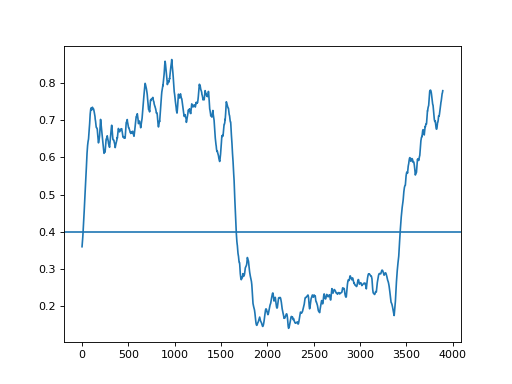

In [291]:

plt.figure()

plt.plot(sm_dist)
#plt.plot(distdrif)
plt.axhline(0.4)
#plt.ylim(0,1)

In [301]:


#framemask[:,np.where(Maskdata > 100000)[1],np.where(smoothed > 100000)[2]] = 0

<IPython.core.display.Javascript object>


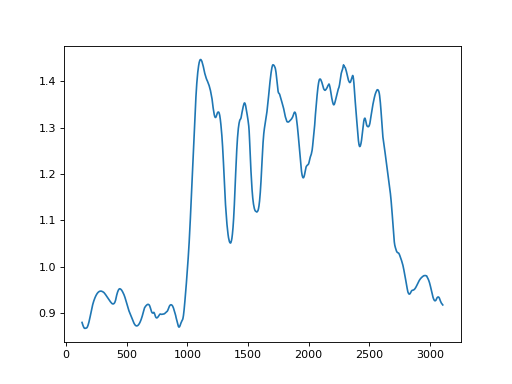

In [308]:
plt.figure()
plt.plot(framemask[:,3,5])

In [38]:
def Long_smooth_limit(Data,Dist):
    x = np.arange(0,len(Data))
    Dist[Dist > 10] = np.nan
    ind = np.isfinite(Dist)
    fun = interp1d(x[ind],Dist[ind],bounds_error = False)
    nonan = fun(x)
    width = 5*48 - 1
    sm_dist = savgol_filter(nonan,width,2,mode='nearest')
    dist_ind = np.where(sm_dist > 0.4)[0]

    X,Y = np.where(np.isfinite(np.nansum(Data,axis=0)))

    smoothed = np.zeros_like(Data)
    limit = np.zeros_like(Data[0]) * np.nan
    for i in range(len(X)):
        lcs = Data[:,X[i],Y[i]]
        lcs[Dist > .3] = np.nan
        ind = np.isfinite(lcs)
        if len(lcs[ind]) > 10:
            fun = interp1d(x[ind],lcs[ind],bounds_error = False)
            nonan = fun(x)
            width = 5*48 - 1
            sm = savgol_filter(nonan,width,2,mode='nearest')
            smoothed[:,X[i],Y[i]] = sm

            pea = find_peaks(sm,distance=4*width)[0]
            maxpeak = pea[np.where(sm[pea] == np.nanmax(sm[pea]))[0]]

            ind = np.arange(0,len(smoothed))
            m_s = ind < int(maxpeak-2*width)
            m_e = ind > int(maxpeak+4*width)
            mean_start = np.nanmean(sm[m_s]) 
            mean_end   = np.nanmean(sm[m_e]) 

            std_start = np.nanstd(sm[m_s])
            std_end = np.nanstd(sm[m_e])
            if maxpeak not in dist_ind:
                if np.isfinite(mean_start) & np.isfinite(mean_end):
                    if mean_end > (mean_start + 3*std_start):
                        print('start only')
                        mean_outside = mean_start
                        std_outside = std_start
                    else:
                        mean_outside = np.nanmean(sm[m_s+m_e])
                        std_outside = np.nanstd(sm[m_s+m_e])
                else:
                    mean_outside = np.nanmean(sm[m_s+m_e])
                    std_outside = np.nanstd(sm[m_s+m_e])
                limit[X[i],Y[i]] = mean_outside +3*std_outside
            else:
                limit[X[i],Y[i]] = np.nan#sm[maxpeak]
        else:
            smoothed[:,X[i],Y[i]] = np.nan
    limit[limit<22] = 22
    return smoothed, limit

def Show_events(eventtime,eventmask,Data,raw):
    for i in range(len(eventtime)):
        lc = Lightcurve(Data,eventmask[i])
        #lc[lc == 0] = np.nan
        plt.figure()
        plt.axvspan(eventtime[i,0],eventtime[i,1],color='orange')
        #plt.plot(Lightcurve(raw,eventmask[i]))
        plt.plot(lc)
        
        

In [32]:
print(np.sum(np.isnan(Maskdata)))

61554


In [33]:
print(np.sum(np.isnan(Maskdata)))
smoothed, limit = Long_smooth_limit(Maskdata.copy(),distdrif.copy())
print(np.sum(np.isnan(Maskdata)))

framemask = (smoothed/limit)
print(np.sum(np.isnan(Maskdata)))

events = []
eventtime = []
eventmask = []
events, eventtime, eventmask = Event_ID(framemask, 1, 10*48,Smoothing=False)
print(np.sum(np.isnan(Maskdata)))
#events, eventtime, eventmask = Vet_brightness(np.copy(events),np.copy(eventtime),eventmask,np.copy(Maskdata),Qual,pixelfile)
events, eventtime, eventmask = Match_events(events,eventtime,eventmask,Maskdata.copy())
print(np.sum(np.isnan(Maskdata)))

events

61554
start only
start only
61554
61554
61554
61554


array([1006,  822])

<IPython.core.display.Javascript object>


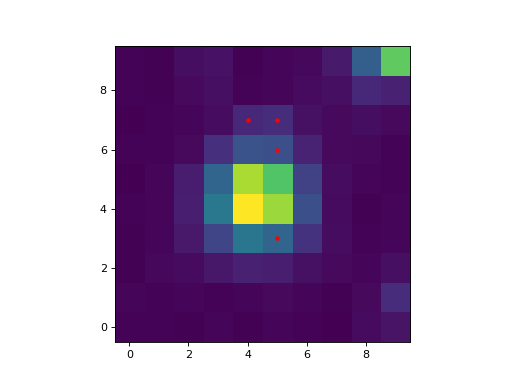

In [34]:
plt.figure()
plt.imshow(datacube[1000],origin='lower')
for e in eventmask:
    plt.plot(e[1],e[0],'r.')



<IPython.core.display.Javascript object>


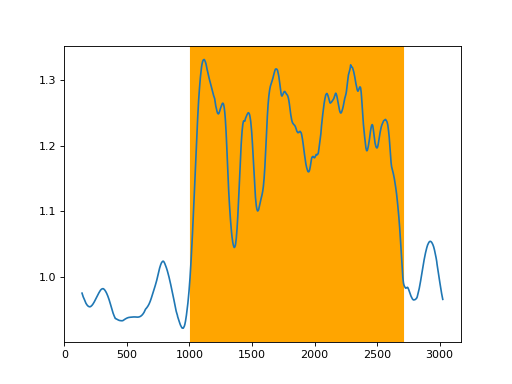

<IPython.core.display.Javascript object>


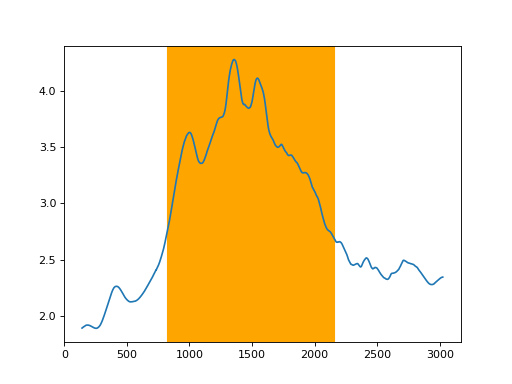

In [39]:
Show_events(eventtime,eventmask,framemask,datacube)

In [108]:
eventmask

[[array([0, 0]), array([11, 12])],
 [array([ 2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14,
         14, 14, 14, 14, 14, 15, 15, 15, 15, 15]),
  array([ 5,  6,  7,  8,  3,  4,  5,  6,  7,  8,  9, 10,  2,  3,  4,  5,  6,
          7,  8,  9, 10, 11,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,
          2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,
          7,  8,  9, 10, 11, 12, 13,  1,  2,  3,  4,  5,  6,  7,  8

<IPython.core.display.Javascript object>


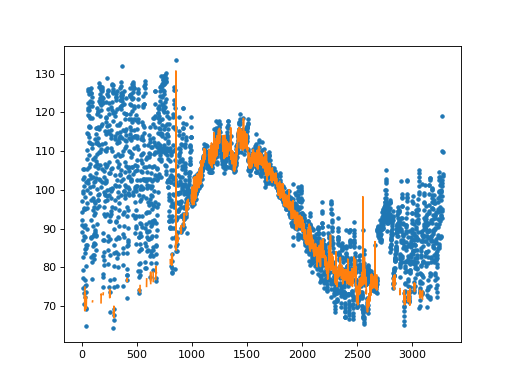

In [9]:
plt.figure()
plt.plot(datacube[:,6,5],'.')
plt.plot(Maskdata[:,6,5])

#for t in thrusters:
#    plt.axvline(t,color='k')

In [21]:
def Median_clip(data, sigma=3):
    med = np.nanmedian(data)
    std = np.nanstd(data)
    mask = data > (med + sigma * std)
    return mask
    

In [22]:
Median_clip(datacube[308:320,6,5])

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
sigma_clip()

In [125]:
def Lightcurve(Data, Mask, Normalise = False):
    if type(Mask) == list:
        mask = np.zeros((Data.shape[1],Data.shape[2]))
        mask[Mask[0],Mask[1]] = 1
        Mask = mask*1.0
    else:
        Mask = Mask * 1.0
    Mask[Mask == 0.0] = np.nan
    LC = np.nansum(Data*Mask, axis = (1,2))
    for k in range(len(LC)):
        if np.isnan(Data[k]*Mask).all(): # np.isnan(np.sum(Data[k]*Mask)) & (np.nansum(Data[k]*Mask) == 0):
            LC[k] = np.nan
    LC[LC == 0] = np.nan
    if Normalise:
        LC = LC / np.nanmedian(LC)
    return LC

In [183]:
eventmask

[[array(3), array(6)],
 [array(3), array(7)],
 [array(3), array(8)],
 [array(4), array(6)],
 [array(4), array(7)],
 [array(4), array(8)],
 [array(4), array(9)],
 [array(5), array(7)],
 [array(5), array(8)],
 [array(5), array(9)],
 [array(5), array(10)],
 [array(6), array(7)],
 [array(6), array(8)],
 [array(7), array(7)],
 [array(7), array(8)],
 [array(7), array(9)],
 [array(8), array(7)],
 [array(8), array(8)],
 [array(9), array(4)],
 [array(9), array(5)],
 [array(9), array(6)],
 [array(10), array(5)],
 [array(10), array(6)],
 [array(11), array(3)],
 [array(11), array(5)],
 [array(11), array(6)],
 [array(12), array(0)],
 [array(13), array(0)],
 [array(14), array(0)]]

In [181]:
t = Event_ID(framemask, 1, 10*48,Smoothing=False)
#plt.figure()
#plt.plot(t)


3 6
3 7
3 8
4 6
4 7
4 8
4 9
4 10
5 7
5 8
5 9
5 10
6 7
6 8
6 9
6 10
7 7
7 8
7 9
7 10
8 5
8 7
8 8
9 4
9 5
9 6
10 5
10 6
10 10
10 11
11 3
11 5
11 6
12 0
13 0
14 0
14 2


In [245]:
def Event_ID(Sigmask, Significance, Minlength, Smoothing = True):
    """
    Identifies events in a datacube, with a primary input of a boolean array for where pixels are 3std above background.
    Event duration is calculated by differencing the positions of False values in the boolean array.
    The event mask is saved as a tuple.
    """
    binary = Sigmask >= Significance


    tarr = np.copy(binary)
    summed_binary = np.nansum(binary,axis=0)
    leng = 10
    X = np.where(summed_binary >= Minlength)[0]
    Y = np.where(summed_binary >= Minlength)[1]

    if Smoothing:
        for i in range(leng-2):
            kern = np.zeros((leng, 1, 1))
            kern[[0, -1]] = 1
            tarr[convolve(tarr*1, kern) > 1] = True
            leng -= 1

    events = []
    eventtime = []
    eventtime = []
    eventmask = []

    for i in range(len(X)):
        temp = np.insert(tarr[:,X[i],Y[i]],0,False) # add a false value to the start of the array
        testf = np.diff(np.where(~temp)[0])
        indf = np.where(~temp)[0]
        testf[testf == 1] = 0
        testf = np.append(testf,0)


        if len(indf[testf>Minlength]) > 0:
            for j in range(len(indf[testf>Minlength])):
                if abs((indf[testf>Minlength][j] + testf[testf>Minlength][j]-1) - indf[testf>Minlength][j]) < 48: # Condition on events shorter than a day 
                    start = indf[testf>Minlength][j]
                    end = (indf[testf>Minlength][j] + testf[testf>Minlength][j]-1)
                    if np.nansum(binary[start:end,X[i],Y[i]]) / abs(end-start) > 0.5:
                        events.append(indf[testf>Minlength][j])
                        eventtime.append([indf[testf>Minlength][j], (indf[testf>Minlength][j] + testf[testf>Minlength][j]-1)])
                        masky = [np.array(X[i]), np.array(Y[i])]
                        eventmask.append(masky)    
                else:
                    events.append(indf[testf>Minlength][j])
                    eventtime.append([indf[testf>Minlength][j], (indf[testf>Minlength][j] + testf[testf>Minlength][j]-1)])
                    masky = [np.array(X[i]), np.array(Y[i])]
                    eventmask.append(masky)

    events = np.array(events)
    eventtime = np.array(eventtime)
    return events, eventtime, eventmask

In [196]:
def Vet_peaks(Events, Eventtime, Eventmask, Data, Smoothdata = True, Short = True):
    good_ind = []
    lcs = []
    peaks = []
    for i in Eventmask:
        lcs += [Lightcurve(Data,i)]
    lcs = np.array(lcs)
    
    for e in range(len(lcs)):
        x = np.arange(0,len(lcs[e]))
        ind = np.isfinite(lcs[e])
        fun = interp1d(x[ind],lcs[e][ind],bounds_error = False,fill_value='extrapolate')
        nonan = fun(x)
        width = ((Eventtime[e,1] - Eventtime[e,0]) * 3) 
        if (width/2) == int(width/2):
            width -= 1
        if Smoothdata:
            sm = savgol_filter(nonan,width,2,mode='nearest')
        else:
            sm = nonan
        pea = find_peaks(sm)[0]
        
        ev_ind = np.where((pea >= Eventtime[e,0]) & (pea <= Eventtime[e,1]))[0]
        max_ind = np.where(np.nanmax(sm[pea])== sm[pea])[0]
        
        if (ev_ind == max_ind).any() & Short:
            stat_ind = pea[pea!=pea[max_ind]]  
            std = np.nanstd(sm[stat_ind])
            med = np.nanmedian(sm[stat_ind])
            sig = (sm[pea[max_ind]] - med) / std
            if sig >= 5:
                if (width * 10) > 48 * 10:
                    check_range = width * 10
                else:
                    check_range = 48 * 10
                tstart = Eventtime[e,0] - check_range
                if tstart < 0:
                    tstart = 0 
                tend = Eventtime[e,1] + check_range
                if tend >= len(Data):
                    tend = len(Data) - 1
                near_peaks = pea[(pea < Eventtime[e,0]) & (pea >= tstart)
                                 | (pea > Eventtime[e,1]) & (pea <= tend)]
                if ((sm[near_peaks] / sm[pea[max_ind]]) < 0.7).all(): 
                    good_ind += [e]
        elif ~Short:
            if (max_ind > 10*48) & (max_ind < (len(Data) - 10*48)):
                good_ind += [e]
                
    good_ind = np.array(good_ind)
    
    if len(good_ind) > 0:
        Events = Events[good_ind]
        Eventtime = Eventtime[good_ind]
        Eventmask = np.array(Eventmask)[good_ind].tolist()
    else:
        Events = np.array([])
        Eventtime = np.array([])
        Eventmask = []
    return Events, Eventtime, Eventmask

In [5]:
t1 = np.where((Qual == 1048576) | (Qual == 1089568) | \
            (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | \
            (Qual == 10240) | (Qual == 32768) | (Qual == 1097760) | \
            (Qual == 1048580) | (Qual == 1081348))[0]
t1 = np.insert(t1,0,-1)
t1 = np.append(t1,len(datacube)-2)

c1 = Correct_motion(datacube, distdrif, t1)



In [6]:
t2 = Get_all_resets(datacube, Qual)
c2 = Correct_motion(datacube, distdrif, t2)

In [9]:
X,Y = np.where(np.isfinite(np.nansum(c1,axis=0)))
x = np.arange(0,len(c1))
s1 = np.zeros_like(c1)
for i in range(len(X)):
    lcs = c1[:,X[i],Y[i]]
    ind = np.isfinite(lcs)
    if len(lcs[ind]) > 10:
        fun = interp1d(x[ind],lcs[ind],bounds_error = False)
        nonan = fun(x)
        width = 10*48 - 1
        sm = savgol_filter(nonan,width,2,mode='nearest')
        s1[:,X[i],Y[i]] = sm
    else:
        s1[:,X[i],Y[i]] = np.nan
        
X,Y = np.where(np.isfinite(np.nansum(c2,axis=0)))
x = np.arange(0,len(c2))
s2 = np.zeros_like(c2)
for i in range(len(X)):
    lcs = c2[:,X[i],Y[i]]
    ind = np.isfinite(lcs)
    if len(lcs[ind]) > 10:
        fun = interp1d(x[ind],lcs[ind],bounds_error = False)
        nonan = fun(x)
        width = 10*48 - 1
        sm = savgol_filter(nonan,width,2,mode='nearest')
        s2[:,X[i],Y[i]] = sm
    else:
        s2[:,X[i],Y[i]] = np.nan